<a href="https://colab.research.google.com/github/TetianaHrunyk/Time-series-analysis/blob/main/NNPricePredictionMultipleSymbols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pprint import pprint
import os
import pickle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

plt.rcParams["figure.figsize"] = (12, 4)
sns.set_style("whitegrid")

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [ ]:
PATH = "drive/MyDrive/Investing and Business/Notebooks/Data"

In [ ]:
SCALERS_FILE_NAME = "scalers.pkl"
CHECKPOINT_FILE_NAME = "LSTM_ADV_MULT_4FEAT_2Y_1H.ckpt"

In [ ]:
SEQ_LEN = 25 #@param {type:"integer"}
BATCH_SIZE = 32 #@param {type:"integer"}

MAX_EPOCHS = 200 #@param {type:"integer"}
PATIENCE = 10 #@param {type:"integer"}

In [ ]:
input_columns = ["Open", "High", "Low", "Close",]# "WeekDay", "Hour"
output_columns = ["Open", "High", "Low", "Close"]
columns_to_scale = ["Open", "High", "Low", "Close"]

In [ ]:
data_path = os.path.join(PATH, "Datasets", "yahoo")
checkpoint_path = os.path.join(PATH, "Checkpoints", CHECKPOINT_FILE_NAME)
scalers_path = os.path.join(PATH, "Datasets", SCALERS_FILE_NAME)

# DATA

In [ ]:
days_map = np.linspace(0, 2*np.pi, 5)
hours_map = np.linspace(0, 2*np.pi, 24)

In [ ]:
df = {}
scalers = {}

for file in os.listdir(data_path):
  if file.endswith(".csv"):
    df_tmp = pd.read_csv(os.path.join(data_path, file))
    df_tmp["Datetime"] = pd.to_datetime(df_tmp["Datetime"])

    df_tmp["WeekDay"] = df_tmp["Datetime"].apply(lambda x: np.sin(days_map[x.weekday()])/2+0.5)
    df_tmp["Hour"] = df_tmp["Datetime"].apply(lambda x: np.sin(hours_map[x.hour])/2+0.5)

    # df_tmp["WeekDay"] = df_tmp["Datetime"].apply(lambda x: x.weekday())
    # df_tmp["Hour"] = df_tmp["Datetime"].apply(lambda x: x.hour)

    symbol = file.split("_")[0]

    train_idx = int(len(df_tmp) * 0.7)
    val_idx = int(len(df_tmp) * 0.9)

    train_df = df_tmp.iloc[:train_idx][:]
    val_df = df_tmp.iloc[train_idx:val_idx][:]
    test_df = df_tmp.iloc[val_idx:][:]

    scalers[symbol] = MinMaxScaler()
    scaler = scalers[symbol]
    scaler.fit(train_df[columns_to_scale])

    train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
    test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])
    val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])

    df[symbol] = {
        "train": train_df,
        "test": test_df,
        "val": val_df
    }

In [ ]:
# df["EURUSD"]["test"]["Hour"].iloc[:200].plot()

In [ ]:
symbols = list(df_tmp.keys())

In [ ]:
# with open(scalers_path, 'w+') as f:
#     scalers = pickle.dump(f)

In [ ]:
# with open(scalers_path, 'rb') as f:
#     scalers = pickle.load(f)

# DATA SET

In [ ]:
# kind = test, train, val
def make_ds(data, kind, batch_size=BATCH_SIZE):
  final_data_set = None
  for values in data.values():
    data_set = tf.keras.utils.timeseries_dataset_from_array(
        data=values[kind][input_columns].iloc[:-SEQ_LEN],
        targets=values[kind].iloc[SEQ_LEN:][output_columns],
        sequence_length=SEQ_LEN,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size)
    if not final_data_set:
      final_data_set = data_set
    else:
      final_data_set.concatenate(data_set)
  final_data_set.shuffle(buffer_size=len(final_data_set))
  return final_data_set

In [ ]:
train_ds = make_ds(df, "train")
val_ds = make_ds(df, "val")
test_ds = make_ds(df, "test", batch_size=1)

In [ ]:
# next(iter(train_ds))

# Training

In [ ]:
def compile_and_fit(model, train, val, max_epochs, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=max_epochs,
                      validation_data=val,
                      callbacks=[early_stopping, checkpoint])
  return history

In [ ]:
def plot_history(history):
  pd.DataFrame(history.history).plot(legend=True)

## Model 1

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=1024, return_sequences=True, input_shape=(SEQ_LEN, len(input_columns))))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.LSTM(units=512, return_sequences=False))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(units=4))

In [ ]:
# Redefine model and load weights
model.load_weights(checkpoint_path)

In [ ]:
history = compile_and_fit(model, train_ds, val_ds, MAX_EPOCHS, PATIENCE)

Epoch 1/200
269/269 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0333
Epoch 1: saving model to drive/MyDrive/Investing and Business/Notebooks/Data/Checkpoints/LSTM_ADV_MULT_4FEAT_2Y_1H.ckpt
269/269 [==============================] - 422s 2s/step - loss: 0.0028 - mean_absolute_error: 0.0333 - val_loss: 2.6182e-04 - val_mean_absolute_error: 0.0134
Epoch 2/200
269/269 [==============================] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0243
Epoch 2: saving model to drive/MyDrive/Investing and Business/Notebooks/Data/Checkpoints/LSTM_ADV_MULT_4FEAT_2Y_1H.ckpt
269/269 [==============================] - 429s 2s/step - loss: 0.0010 - mean_absolute_error: 0.0243 - val_loss: 1.0456e-04 - val_mean_absolute_error: 0.0075
Epoch 3/200
269/269 [==============================] - ETA: 0s - loss: 9.7868e-04 - mean_absolute_error: 0.0239
Epoch 3: saving model to drive/MyDrive/Investing and Business/Notebooks/Data/Checkpoints/LSTM_ADV_MULT_4FEAT_2Y_1H.c

In [ ]:
# plot_history(history)

In [ ]:
# model.save(model_path)

# Test performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

In [ ]:
model.evaluate(test_ds)

RuntimeError: ignored

In [ ]:
# model = tf.keras.models.load_model(model_path)

In [ ]:
def get_eval_metrix(test_ds):
  actual = np.concatenate([labels for inputs, labels in test_ds]).squeeze()
  predictions = model.predict(test_ds)

  errors = {"MSE": {}, "MAE": {}}
  for act_col, pred_col, label in zip(actual.T, predictions.T, columns_to_scale):
    mse = mean_squared_error(act_col, pred_col)
    mae = mean_absolute_error(act_col, pred_col)
    errors["MSE"][label] = mse
    errors["MAE"][label] = mae

  return pd.DataFrame(errors)

In [ ]:
eval_metrics = get_eval_metrix(test_ds)

1193/1193 [==============================] - 53s 44ms/step


In [ ]:
eval_metrics

,MSE,MAE
Open,0.003959,0.050800
High,0.004182,0.052371
Low,0.003976,0.050883
Close,0.004013,0.051175


# Visualize predictions

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def visualize_sample(data, scalers, seq_len, pred_len, symbol=None):
  if symbol not in data.keys():
    symbol = random.choice(list(data.keys()))
  df = data[symbol]["test"]
  scaler = scalers[symbol]

  idx = np.random.randint(0, len(df)-seq_len-pred_len-2)
  sample_seq = df.iloc[idx:idx+seq_len+pred_len]

  datetime_idx= pd.to_datetime(sample_seq["Datetime"])

  inputs = sample_seq.iloc[:seq_len][input_columns]

  for i in range(pred_len):
    prediction = model(np.expand_dims(inputs.iloc[-seq_len:].values, axis=0))
    row = [*list(prediction.numpy().squeeze()), datetime_idx.iloc[-seq_len+i].weekday(), datetime_idx.iloc[-seq_len+i].hour]
    inputs.loc[len(inputs.index)] = {key: val for key, val in zip(df.columns[1:], row)}

  sample_seq[columns_to_scale] = scaler.inverse_transform(sample_seq[columns_to_scale])
  plt.scatter(x=datetime_idx, y=sample_seq.Open, label="True data")

  inputs[columns_to_scale] = scaler.inverse_transform(inputs[columns_to_scale])
  plt.scatter(x=datetime_idx[-pred_len:], y=inputs.iloc[-pred_len:].Open, color="orange", marker="x", label="Prediction")

  plt.title(f"Prediction on {symbol}")
  plt.legend();

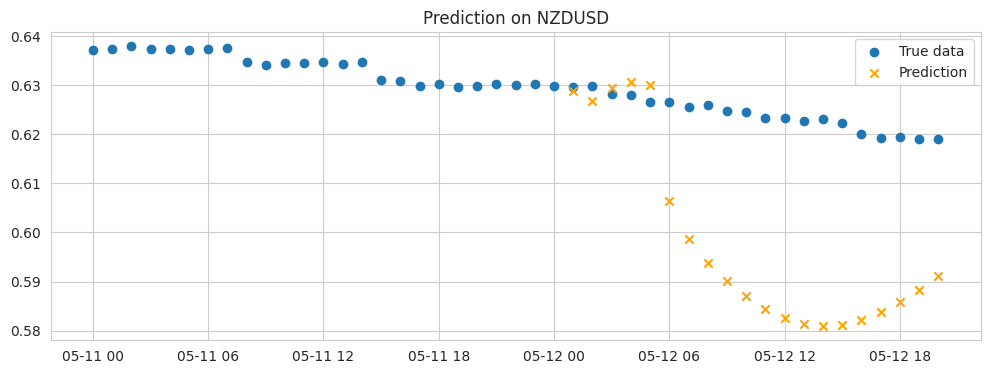

In [ ]:
visualize_sample(df, scalers, SEQ_LEN, 20)